In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.fft import rfft, rfftfreq, irfft
import numpy
import math
from scipy.signal import find_peaks
import seaborn as sns
from scipy.interpolate import CubicSpline
from scipy.signal import savgol_filter
import statistics

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
arinaNormal = pd.read_csv('norm_arina.csv', index_col=0)
arinaStress = pd.read_csv('stress_arina.csv', index_col=0)
arinaMonotony = pd.read_csv('monotony_arina.csv', index_col=0)

lyubaNormal = pd.read_csv('norm_lyuba.csv', index_col=0)
lyubaStress = pd.read_csv('stress_lyuba.csv', index_col=0)
lyubaMonotony = pd.read_csv('monotony_lyuba.csv', index_col=0)

mashaNormal = pd.read_csv('norm_maria.csv', index_col=0)
mashaStress = pd.read_csv('stress_maria.csv', index_col=0)
mashaMonotony = pd.read_csv('monotony_maria.csv', index_col=0)

lyubaFinal = pd.read_csv('lyuba_final_test.csv', index_col=0)
lyubaFinal.head(1)

time  ecg  fpg  gsr  difficulties
0  1684078964077  660  295  427           0.0

# 

# Нормализация времени

In [3]:
def normalizateTime(dataFrame):
    print("Строк до    :" + str(len(dataFrame)))
    dataFrame = dataFrame.drop_duplicates(subset=['time'])
    print("Строк после :" + str(len(dataFrame)))
    dataFrame = dataFrame.tail(len(dataFrame) - 100)
    dataFrame = dataFrame.reset_index()

    startTime = dataFrame["time"][0]
#     print(times[0])
    newTimes = []

    for index, row in dataFrame.iterrows():
        currentTime = row["time"]
        currentTime -= startTime
        currentTime /= 1000
        newTimes.append(currentTime)

    dataFrame["time"] = newTimes
    print("Длительность записи: " + str(dataFrame["time"][len(dataFrame) - 1]) + " секунд")
    
    return dataFrame

In [4]:
def addDifficult(dataFrame, leftStart, centreStart, rightStart, leftEnd, centreEnd, rightEnd):
    sampleRate = round(len(dataFrame) / dataFrame["time"][len(dataFrame) - 1])
    print(sampleRate)

    sourceDifficults = []

    difficultLeft   = leftStart
    difficultCentre = centreStart
    difficultRight  = rightStart

    for i in range(60 * 60 * 50):
        if leftStart < leftEnd and difficultLeft   < leftEnd:
            difficultLeft   = leftStart   + i * 0.00005
        if centreStart < centreEnd and difficultCentre < centreEnd:
            difficultCentre = centreStart + i * 0.00005
        if rightStart < rightEnd and difficultRight  < rightEnd:
            difficultRight  = rightStart  + i * 0.00005
            
        if leftStart > leftEnd and difficultLeft   > leftEnd:
            difficultLeft   = leftStart   - i * 0.00005
        if centreStart > centreEnd and difficultCentre > centreEnd:
            difficultCentre = centreStart - i * 0.00005
        if rightStart > rightEnd and difficultRight  > rightEnd:
            difficultRight  = rightStart  - i * 0.00005

        sourceDifficults.append(difficultLeft + difficultCentre + difficultRight)
        
    normalizedDifficult = []
    
    for i in range(len(dataFrame)):
        normalizedDifficult.append(sourceDifficults[round(i * 60 / sampleRate)])
    
    dataFrame["difficult"] = normalizedDifficult
    return dataFrame

In [5]:
arinaNormal = normalizateTime(arinaNormal)
arinaNormal = addDifficult(arinaNormal, 1.5, 2, 2.5, 3, 3.5, 4)
arinaStress = normalizateTime(arinaStress)
arinaStress = addDifficult(arinaStress, 1.5, 2, 2.5, 6, 7, 8)
arinaMonotony = normalizateTime(arinaMonotony)
arinaMonotony = addDifficult(arinaMonotony, 2, 2.5, 3, 0.75, 1.25, 1.75)

lyubaNormal = normalizateTime(lyubaNormal)
lyubaNormal = addDifficult(lyubaNormal, 1.5, 2, 2.5, 3, 3.5, 4)
lyubaStress = normalizateTime(lyubaStress)
lyubaStress = addDifficult(lyubaStress, 1.5, 2, 2.5, 6, 7, 8)
lyubaMonotony = normalizateTime(lyubaMonotony)
lyubaMonotony = addDifficult(lyubaMonotony, 2, 2.5, 3, 0.75, 1.25, 1.75)

mashaNormal = normalizateTime(mashaNormal)
mashaNormal = addDifficult(mashaNormal, 1.5, 2, 2.5, 3, 3.5, 4)
mashaStress = normalizateTime(mashaStress)
mashaStress = addDifficult(mashaStress, 1.5, 2, 2.5, 6, 7, 8)
mashaMonotony = normalizateTime(mashaMonotony)
mashaMonotony = addDifficult(mashaMonotony, 2, 2.5, 3, 0.75, 1.25, 1.75)

Строк до    :90942
Строк после :90884
Длительность записи: 2455.46 секунд
37
Строк до    :92019
Строк после :91661
Длительность записи: 2474.211 секунд
37
Строк до    :88192
Строк после :87857
Длительность записи: 2372.175 секунд
37
Строк до    :101412
Строк после :101045
Длительность записи: 2625.263 секунд
38
Строк до    :91403
Строк после :91113
Длительность записи: 2367.518 секунд
38
Строк до    :84040
Строк после :83672
Длительность записи: 2173.339 секунд
38
Строк до    :58395
Строк после :58364
Длительность записи: 1576.303 секунд
37
Строк до    :68555
Строк после :68507
Длительность записи: 1848.737 секунд
37
Строк до    :88543
Строк после :88323
Длительность записи: 2386.273 секунд
37


In [6]:
sampleRate = round(len(lyubaNormal) / lyubaNormal["time"][len(lyubaNormal) - 1])
sampleRate

38

In [7]:
lyubaNormal.head(4500)

index     time  ecg  fpg  gsr  leftErrors  centreErrors  rightErrors  \
0       367    0.000  352  345  330         0.0           0.0          0.0   
1       370    0.001  354  347  330         0.0           0.0          0.0   
2       374    0.002  390  344  331         0.0           0.0          0.0   
3       378    0.003  415  353  331         0.0           0.0          0.0   
4       382    0.004  356  347  333         0.0           0.0          0.0   
...     ...      ...  ...  ...  ...         ...           ...          ...   
4495   4962  116.029  324  358  318         0.0           0.0          0.0   
4496   4963  116.053  327  355  318         0.0           0.0          0.0   
4497   4964  116.082  327  355  321         0.0           0.0          0.0   
4498   4965  116.107  360  356  318         0.0           0.0          0.0   
4499   4966  116.132  353  356  317         0.0           0.0          0.0   

      difficult  
0       6.00000  
1       6.00030  
2       6.00045  
3       6.00075  
4       6.00090  
...         ...  
4495    7.06455  
4496    7.06485  
4497    7.06515  
4498    7.06530  
4499    7.06560  

[4500 rows x 9 columns]

# 

# Фильтрация, нормализация

In [8]:
def calcMetric(data, timeIndex):
    
    left = data["leftErrors"]
    left = left.reset_index(drop = True)
    left = left[left > 1]
    leftAccuracy = left.mean()
    centre = data["centreErrors"]
    centre = centre.reset_index(drop = True)
    centre = centre[centre > 1]
    centreAccuracy = centre.mean()
    right = data["rightErrors"]
    right = right.reset_index(drop = True)
    right = right[right > 1]
    rightAccuracy = right.mean()
    meanAccuracy = (leftAccuracy + centreAccuracy + rightAccuracy) / 3
    meanError = 100 - meanAccuracy

    # Нормализация КГР
    mean = data["gsr"].mean()
    gsr = (data["gsr"] - mean)
    gsrMean = gsr.mean()
    gsrStd = gsr.std(ddof = 0)

    # Нормализация ЭКГ
    mean = data["ecg"].mean()
    ecg = (data["ecg"] - mean) * 2
    ecg = ecg.to_numpy()


    # Фильтрация ЭКГ
    yf = rfft(ecg)
    xf = rfftfreq(len(ecg), 1 / sampleRate)
    for i in range(len(xf)):
        if xf[i] < 0.5 or xf[i] > 15:
            yf[i]=0      
    filteredECG = irfft(yf)
    if len(ecg) > len(filteredECG):
        filteredECG = numpy.append(filteredECG, filteredECG[len(filteredECG) - 1])


    # Расчёт пороговых линий при поиске R и R-T зубцов
    summ = 0
    count = 0
    for x in filteredECG:
        if x > 0:
            summ += x * 1.5
            count += 1
    rline = summ / count
    tline = summ / len(filteredECG)

    # Поиск R-зубцов
    rPeaks, _ = find_peaks(filteredECG, height = rline, distance = 15)
    rPeaks = rPeaks.tolist()

    qPeaks = []
    sPeaks = []

    # Поиск Q и S-зубцов
    for i in range(0, len(rPeaks)):
        qPeakIndex = rPeaks[i]
        sPeakIndex = rPeaks[i]

        while filteredECG[qPeakIndex] > filteredECG[qPeakIndex - 1]: # Поиск Q-зубца
            qPeakIndex -= 1

        while True: # Поиск S-зубца
            if((sPeakIndex + 1) == len(filteredECG)): # Если при поиске S-зубца происходит выход за рамки массива,
                                                        #   то это ошибочный R-зубец, который необходимо удалить
                del rPeaks[-1]
                break
            elif (filteredECG[sPeakIndex] > filteredECG[sPeakIndex + 1]):
                sPeakIndex += 1
            else: break

        qPeaks.append(qPeakIndex)
        sPeaks.append(sPeakIndex)

    # Т.к. ЭКГ и ФПГ подключены к одному источнику напряжения, то их показания частично регистрируются в графикаъ друг-друга.
    #   На ЭКГ виден пик левее Q-зубца, который является систольным зубцом из ФПГ, его необходимо удалить
    for qPeak in qPeaks:
        delLeftWidth = 5
        for i in range(qPeak - delLeftWidth, qPeak):
            filteredECG[i] = 0

    # После удаления систольного выброса, на ЭКГ остаются только R и T-зубцы. Теперь можно определить последние
    tPeaks = []
    rtPeaks, _ = find_peaks(filteredECG, height = tline, distance = 5)
    rtPeaks = rtPeaks.tolist()

    # Нахождение только T-пиков
    for rtPeak in rtPeaks:
        if rtPeak not in rPeaks:
            tPeaks.append(rtPeak)

    # Нормализация ФПГ относительно нуля с параллельным домножением на коэффициент с целью увеличения заметности зубцов
    mean = data["fpg"].mean()
    fpg = (data["fpg"] - mean) * 50
    fpg = fpg.to_numpy()

    # На ФПГ ошибочно регистрируются R-зубцы ЭКГ. Т.к. их места нам уже известны, то их можно легко удалить
    for rPeak in rPeaks:
        windowWidth = 3
        for i in range(rPeak - windowWidth, rPeak + windowWidth):
            fpg[i] = -100

    # Фильтрация остаточного графика ФПГ
    yf = rfft(fpg)
    xf = rfftfreq(len(fpg), 1 / sampleRate)
    for i in range(len(xf)):
        if xf[i] < 0.5 or xf[i] > 3:
            yf[i]=0      
    filteredFPG = irfft(yf)
#     if len(times) > len(filteredFPG):
#         filteredFPG = numpy.append(filteredFPG, filteredFPG[len(filteredFPG) - 1])

    # Зануление отрицательной части графика. Тем самым остаются только интересующие зубцы
    for i in range(len(filteredFPG)):
        if filteredFPG[i] < 0:
            filteredFPG[i] = 0

    # Нахождение зубцов ФПГ
    fpgPeaks, _ = find_peaks(filteredFPG, height = 0, distance = 8)
    fpgPeaks = fpgPeaks.tolist()

    # Между двумя ударами сердца (R-зубцы ЭКГ) всегда регистрируются 2 пика ФПГ (систольный и диастольный).
    # Качество записи ФПГ не всегда позволяет определить точное положение диастольного зубца, так что здесь ищется только систольный
    systolePeaks = []
    systolIndex = 0
    sysDisPeaks = 2
    diffRSys = []
    
    for rPeak in rPeaks:
        while systolIndex < len(fpgPeaks) and fpgPeaks[systolIndex] < rPeak:
            systolIndex += 1
            sysDisPeaks += 1
        if systolIndex < len(fpgPeaks) and sysDisPeaks == 2:
            systolePeaks.append(fpgPeaks[systolIndex - sysDisPeaks])
            diffRSys.append(fpgPeaks[systolIndex] - rPeak)
        sysDisPeaks = 0

    
    
    
    # Расчёт метрик
    # Получение RR-интервалов    
    rrIntervals = [] # Размер интервала между соседними R-зубцами в мс
    correctedRPeaks = []

    for i in range(len(rPeaks) - 1):
        rrInterval = (rPeaks[i + 1] - rPeaks[i]) / sampleRate * 1000
#         print(rrInterval)
        if rrInterval < 1300:
            rrIntervals.append(rrInterval)
            correctedRPeaks.append(rPeaks[i])
        else:
            missedPeak = round(((rPeaks[i + 1] - rPeaks[i]) / 2) + rPeaks[i]) - 0
            correctedRPeaks.append(rPeaks[i])
            correctedRPeaks.append(missedPeak)
#             print(rrInterval)
#             print(rPeaks[i])
#             print(rPeaks[i + 1])
#             print(missedPeak)
            rrIntervals.append((missedPeak - rPeaks[i]) / sampleRate * 1000)
            rrIntervals.append((rPeaks[i + 1] - missedPeak) / sampleRate * 1000)
#             print(rrIntervals)
#             print()
    rPeaks = correctedRPeaks
    
    
    
    xData = []
    prev = 0
    current = 0

    yData = rrIntervals

    for i in range(len(yData)):
        current = prev + yData[i] / 1000
        xData.append(round(current, 3))
        prev = current
        
    interpolateSpline = CubicSpline(xData, yData)
    newX = numpy.arange(0, xData[len(xData) - 1], 0.25)
    newY = interpolateSpline(newX)
    
    yf = rfft(newY) # мощность волн определённой частоты на графике
    xf = rfftfreq(len(newY), 0.25) # список всех частот на графике

    spm = [] # Спектральная Плотность Мощности
    n = len(yf)
    Xk = 0

    for i in range(1, len(yf)):
        Xk = numpy.abs(yf[i])
        spm.append(Xk**2 / n**2)
        
    # Границы интервалов 
    idx004 = numpy.argmin(numpy.abs(xf - 0.04))
    idx015 = numpy.argmin(numpy.abs(xf - 0.15))
    idx04 = numpy.argmin(numpy.abs(xf - 0.4))

    # Интервалы (0.015 Гц, 0.04 Гц, 0.15 Гц, 0.4 Гц)
    ΔLF =  spm[idx004 + 1 : idx015]  # 0.04  - 0.15  Гц
    ΔHF =  spm[idx015 + 1 : idx04]   # 0.15  - 0.04  Гц

    # Сумма мощностей в заданном интервале. Используется для определения активности определённых отделов организма
    LFsum = round(sum(ΔLF), 3)
    HFsum = round(sum(ΔHF), 3)

    LFHF = LFsum / HFsum

    # Отделы:
    # HF -  активность симпатического отдела
    # LF -  системы регуляции сосудистого тонуса,осуществляемой вазомоторным центром продолговатого мозга.
    # VLF - психоэмоциональное напряжение и функциональное состояние коры головного мозга
    # ULF - сильно критикуется и редко используется
    
    
    
    # Получение кардиоинтервальной гистограммы     
    minimumECG = round(min(rrIntervals))
    maximumECG = round(max(rrIntervals))
    valuesECG = []
    countsECG = []
    tempConvert = pd.Series(rrIntervals)
    for i in range(minimumECG, maximumECG, 50):
        countsECG.append(tempConvert.where(tempConvert >= i).where(tempConvert < i + 50).count())
        valuesECG.append(i)
            
            
        
    # Статистические метрики RR-интервалов
    rrIntervals = numpy.array(rrIntervals)
    # Математическое ожидание (RRNN) (Среднее значение)
    MoRR = round(rrIntervals.mean() / 1000, 3)
    # Среднеквадратичное отклонение (SDNN) (Средний разброс элементов относительно мат. ожидания)
    StdRR = round(rrIntervals.std(ddof = 0) / 1000, 3)
    # Коэффициент вариации (CV) (То же среднеквадратичное отклонение, но с нормировкой по пульсу)
    CVRR = round(StdRR / MoRR * 100, 3)
    
    PulseRR = round((1/ MoRR) * 60)
    PulseStd = rrIntervals.std(ddof = 0)
    
    # Метрики по Баевскому
    # Мода (Наиболее часто встречающееся значение)
    MoInt = round((valuesECG[(len(valuesECG) // 2) - 1] + 25) / 1000,2)
    # Амплитуда моды (Процент значений входящих в моду)
    AMoInt = round(countsECG[(len(valuesECG) // 2) - 1] / len(rrIntervals) * 100,2)
    # Вариационный размах (Максимальная амплитуда значений)
    DXInt = round((maximumECG - minimumECG) / 1000,2)
    # Вегетативный показатель ритма (Чем меньше ВПР, тем больше преобладает парасимпатический отдел)
    VPRInt = round(1 / (MoInt * DXInt),2)
    # Индекс напряжения регуляторных систем (Чем ниже, там сильнее парасимпатика. Чем выше, тем сильнее симпатика)
    INInt = round(AMoInt / (2 * DXInt * MoInt),2)
    
    corrGSRECG = numpy.corrcoef(gsr, ecg)[0, 1]
    meanDifRSysFPG = numpy.array(diffRSys).mean()
    
    
    return filteredFPG, fpgPeaks, systolePeaks, filteredECG, rPeaks, rrIntervals, pd.Series({"timeId": timeIndex, "meanGSR": gsrMean, "gsrStd": gsrStd, "corrGSRECG": corrGSRECG,
#     return pd.Series({"timeId": timeIndex, "meanGSR": gsrMean, "gsrStd": gsrStd, "corrGSRECG": corrGSRECG,
                      "meanDifRSysFPG":meanDifRSysFPG, "LF/HF": LFHF, "meanError": meanError, "numberOfPeaks": len(rPeaks),
                      "meanAccuracy": meanAccuracy, "difficult": data.tail(1)["difficult"].to_list()[0], 
                      "PulseRR": PulseRR, "PulseStd": PulseStd, "MoRR": MoRR, "StdRR": StdRR, "CVRR": CVRR,
                      "MoInt": MoInt, "AMoInt": AMoInt, "DXInt": DXInt, "VPRInt": VPRInt, "INInt": INInt})
    
    
#     plt.figure(figsize=(23, 9))
#     # plt.plot(ecg, label="До фильтрации")
#     plt.plot(filteredECG, label="ЭКГ")
#     # plt.plot(qPeaks, filteredECG[qPeaks], "H", color = "g", label='Q-зубцы')
#     plt.plot(rPeaks, filteredECG[rPeaks], "X", color = "r", label='R-зубцы')
#     # plt.plot(sPeaks, filteredECG[sPeaks], "s", color = "y", label='S-зубцы')
#     # plt.plot(tPeaks, filteredECG[tPeaks], "o", color = "b", label='T-зубцы')
#     # plt.plot(fpg, label="ФПГ")
#     # plt.plot(fpgPeaks, filteredFPG[fpgPeaks], "X", color = "orange", label='Систольные зубцы')
#     # plt.plot(systolePeaks, filteredFPG[systolePeaks], "X", color = "b", label='Систольные зубцы')
#     # plt.plot(filteredFPG, label="ФПГ")
#     plt.axhline(y = rline, color='r', linestyle='-')
#     plt.axhline(y = tline, color='c', linestyle='-')
#     plt.legend(loc="best")
#     plt.show()

# Разбиение выборки и рсчёт метрик

In [9]:
def calsMetrics(data):
    windowStep = 200 # 10 секунд при частоте в 38 ГЦ
    windowWidth = 4500 # 2 минуты при частоте в 38 ГЦ

    filteredFPGs = []
    fpgPeaks = []
    systolePeaks = []
    filteredECGs = []
    rPeaks = []
    rrIntervals = []
    metrics = pd.DataFrame()
    
    for i in range(0, len(data), windowStep):
        dataFrame = data.loc[i : i + windowWidth]
        if len(dataFrame) > 2000:
            
            filteredFPG, fpgPeak, systolePeak, filteredECG, rPeak, rrInterval, metric = calcMetric(dataFrame, i + windowWidth)
            filteredFPGs.append(filteredFPG)
            fpgPeaks.append(fpgPeak)
            systolePeaks.append(systolePeak)
            filteredECGs.append(filteredECG)
            rPeaks.append(rPeak)
            rrIntervals.append(rrInterval)
            
#             metric = calcMetric(dataFrame, i + windowWidth)

            metrics = pd.concat([metrics, metric.to_frame().T], ignore_index=True)
            
    return filteredFPGs, fpgPeaks, systolePeaks, filteredECGs, rPeaks, rrIntervals, metrics
#     return metrics

In [10]:
def normalizeData(data):
    return (data - numpy.min(data)) / (numpy.max(data) - numpy.min(data))

In [11]:
# filteredECGs, rPeaks, rrIntervals, normalMetrics = calsMetrics(dataMonotony)

arinaNormalfilteredFPGs, arinaNormalfpgPeaks, arinaNormalsystolePeaks, arinaNormalfilteredECGs, arinaNormalrPeaks, arinaNormalrrIntervals, arinaNormalMetrics = calsMetrics(arinaNormal)
arinaStressfilteredFPGs, arinaStressfpgPeaks, arinaStresssystolePeaks, arinaStressfilteredECGs, arinaStressrPeaks, arinaStressrrIntervals, arinaStressMetrics = calsMetrics(arinaStress)
arinaMonotonyfilteredFPGs, arinaMonotonyfpgPeaks, arinaMonotonysystolePeaks, arinaMonotonyfilteredECGs, arinaMonotonyrPeaks, arinaMonotonyrrIntervals, arinaMonotonyMetrics = calsMetrics(arinaMonotony)

lyubaNormalfilteredFPGs, lyubaNormalfpgPeaks, lyubaNormalsystolePeaks, lyubaNormalfilteredECGs, lyubaNormalrPeaks, lyubaNormalrrIntervals, lyubaNormalMetrics = calsMetrics(lyubaNormal)
lyubaStressfilteredFPGs, lyubaStressfpgPeaks, lyubaStresssystolePeaks, lyubaStressfilteredECGs, lyubaStressrPeaks, lyubaStressrrIntervals, lyubaStressMetrics = calsMetrics(lyubaStress)
lyubaMonotonyfilteredFPGs, lyubaMonotonyfpgPeaks, lyubaMonotonysystolePeaks, lyubaMonotonyfilteredECGs, lyubaMonotonyrPeaks, lyubaMonotonyrrIntervals, lyubaMonotonyMetrics = calsMetrics(lyubaMonotony)

mashaNormalfilteredFPGs, mashaNormalfpgPeaks, mashaNormalsystolePeaks, mashaNormalfilteredECGs, mashaNormalrPeaks, mashaNormalrrIntervals, mashaNormalMetrics = calsMetrics(mashaNormal)
mashaStressfilteredFPGs, mashaStressfpgPeaks, mashaStresssystolePeaks, mashaStressfilteredECGs, mashaStressrPeaks, mashaStressrrIntervals, mashaStressMetrics = calsMetrics(mashaStress)
mashaMonotonyfilteredFPGs, mashaMonotonyfpgPeaks, mashaMonotonysystolePeaks, mashaMonotonyfilteredECGs, mashaMonotonyrPeaks, mashaMonotonyrrIntervals, mashaMonotonyMetrics = calsMetrics(mashaMonotony)

In [12]:
mashaStressMetrics.tail(1)

timeId       meanGSR    gsrStd  corrGSRECG  meanDifRSysFPG     LF/HF  \
332  70900.0  1.359484e-15  5.206895   -0.020512        11.53125  0.346046   

     meanError  numberOfPeaks  meanAccuracy  difficult  PulseRR   PulseStd  \
332   7.407631           61.0     92.592369       21.0     70.0  95.795534   

      MoRR  StdRR    CVRR  MoInt  AMoInt  DXInt  VPRInt  INInt  
332  0.858  0.096  11.189   0.85   50.82   0.81    1.45  36.91

# Расчёт метрик функции состояния

In [15]:
def calcStateMetrics(dataMetrics):

    sourceFrame = dataMetrics

#     leftTime = round(sampleRate * 60 * leftMinutes - 4500)
#     rightTime = round(sourceFrame.tail(1)["timeId"].to_list()[0] - (sampleRate * 60 * rightMinutes - 4500))

    sourcePulse = sourceFrame["PulseRR"].to_list()
    pulseChange = [0]
    for i in range(1, len(sourcePulse)):
        pulseChange.append(abs(sourcePulse[i] - sourcePulse[i - 1]))
    pulseChange = normalizeData(numpy.array(savgol_filter(pulseChange, 71, 3)))

    sourceINInt = savgol_filter(sourceFrame["INInt"], 51, 3)
    INIntChange = [0]
    for i in range(1, len(sourceINInt)):
        INIntChange.append(abs(sourceINInt[i] - sourceINInt[i - 1]))
    INIntChange = normalizeData(numpy.array(savgol_filter(INIntChange, 35, 3)))

    sourceDifRSysFPG = savgol_filter(sourceFrame["meanDifRSysFPG"], 35, 3)
    difRSysFPGChange = [0]
    for i in range(1, len(sourceDifRSysFPG)):
        difRSysFPGChange.append(abs(sourceDifRSysFPG[i] - sourceDifRSysFPG[i - 1]))
    difRSysFPGChange = normalizeData(numpy.array(savgol_filter(difRSysFPGChange, 35, 3)))

    sourcegsrStd = savgol_filter(sourceFrame["gsrStd"], 35, 3)
    gsrStdChange = [0]
    for i in range(1, len(sourcegsrStd)):
        gsrStdChange.append(abs(sourcegsrStd[i] - sourcegsrStd[i - 1]))
    gsrStdChange = normalizeData(numpy.array(savgol_filter(gsrStdChange, 35, 3)))

    errorDifficult = normalizeData(numpy.array(savgol_filter(sourceFrame["meanError"] / sourceFrame["difficult"], 35, 3)))


    stateMetrics = pd.DataFrame({"timeId": sourceFrame["timeId"], "pulseChange": pulseChange, "error/difficult": errorDifficult,
                                 "INIntChange": INIntChange, "difRSysFPGChange": difRSysFPGChange, "gsrStdChange": gsrStdChange})
    stateMetrics = stateMetrics.set_index('timeId')
    
    return stateMetrics

In [16]:
lyubaStressStateMetrics = calcStateMetrics(lyubaStressMetrics)
lyubaNormalStateMetrics = calcStateMetrics(lyubaNormalMetrics)
lyubaMonotonyStateMetrics = calcStateMetrics(lyubaMonotonyMetrics)

arinaStressStateMetrics = calcStateMetrics(arinaStressMetrics)
arinaNormalStateMetrics = calcStateMetrics(arinaNormalMetrics)
arinaMonotonyStateMetrics = calcStateMetrics(arinaMonotonyMetrics)

mashaStressStateMetrics = calcStateMetrics(mashaStressMetrics)
mashaNormalStateMetrics = calcStateMetrics(mashaNormalMetrics)
mashaMonotonyStateMetrics = calcStateMetrics(mashaMonotonyMetrics)

mashaStressStateMetrics.head(1)

pulseChange  error/difficult  INIntChange  difRSysFPGChange  \
timeId                                                                
4500.0     0.747153              1.0     0.199973          0.120213   

        gsrStdChange  
timeId                
4500.0      0.279754

# Расчёт состояния

In [17]:
def calcState(metrics):
    state = savgol_filter(numpy.array(metrics.sum(axis=1)), 95, 3)
    stateObratniy = abs(state - max(state))
    
    metrics.loc[:,'state'] = state
    metrics.loc[:,'stateObratniy'] = stateObratniy
    return metrics

In [18]:
lyubaStressMetricsWithState = calcState(lyubaStressStateMetrics)
lyubaNormalMetricsWithState = calcState(lyubaNormalStateMetrics)
lyubaMonotonyMetricsWithState = calcState(lyubaMonotonyStateMetrics)

arinaStressMetricsWithState = calcState(arinaStressStateMetrics)
arinaNormalMetricsWithState = calcState(arinaNormalStateMetrics)
arinaMonotonyMetricsWithState = calcState(arinaMonotonyStateMetrics)

mashaStressMetricsWithState = calcState(mashaStressStateMetrics)
mashaNormalMetricsWithState = calcState(mashaNormalStateMetrics)
mashaMonotonyMetricsWithState = calcState(mashaMonotonyStateMetrics)

mashaStressMetricsWithState.head(1)

pulseChange  error/difficult  INIntChange  difRSysFPGChange  \
timeId                                                                
4500.0     0.747153              1.0     0.199973          0.120213   

        gsrStdChange     state  stateObratniy  
timeId                                         
4500.0      0.279754  2.137255       0.375389

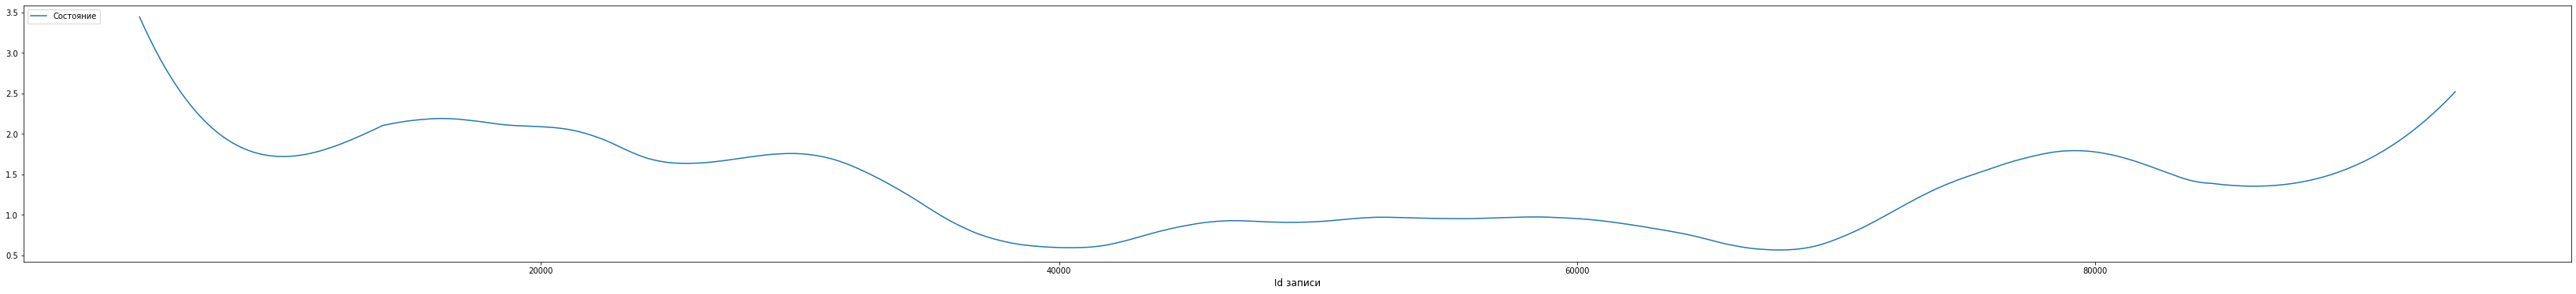

In [19]:
plt.figure(figsize=(58, 6))

# plt.plot(sourceFrame.index, normalizeData(numpy.array(sourceFrame["meanError"])), label="Ошибка")
# plt.plot(stateMetrics.index, savgol_filter(stateMetrics["state"], 75, 3), label="Состояние")
plt.plot(arinaStressMetricsWithState.index, arinaStressMetricsWithState["state"], label="Состояние")
# plt.plot(lyubaStressMetricsWithState.index, lyubaStressMetricsWithState["stateObratniy"], label="Обратное состояние")
# plt.plot(dataMetrics["timeId"], savgol_filter(dataMetrics["difficult"], 35, 3), label="Сложность")
# plt.plot(dataMetrics["timeId"], normalizeData(numpy.array(savgol_filter(dataMetrics["meanError"] / dataMetrics["difficult"], 35, 3))), label="Косячность")
# plt.plot(stateMetrics.index, stateMetrics["pulseChange"], label="Изменение пульса")
# plt.plot(sourceFrame.index, normalizeData(numpy.array(sourceFrame["PulseRR"])), label="Пульс")
# plt.plot(stateMetrics.index, stateMetrics["INIntChange"], label="Изменение ИН")
# plt.plot(sourceFrame.index, normalizeData(numpy.array(sourceFrame["INInt"])), label="ИН")
# plt.plot(stateMetrics.index, stateMetrics["difRSysFPGChange"], label="Изменение RR-FPG")
# plt.plot(sourceFrame.index, normalizeData(numpy.array(sourceFrame["meanDifRSysFPG"])), label="RR-FPG")
# plt.plot(stateMetrics.index, stateMetrics["gsrStdChange"], label="Изменение GSR")
# plt.plot(sourceFrame.index, normalizeData(numpy.array(sourceFrame["gsrStd"])), label="GSR std")

plt.xlabel('Id записи', fontsize=12)
plt.legend(loc='upper left')
plt.show()

# Нахождение локальных экстремумов функции состояния

In [20]:
def calcStatePeaks(sourceState, minMinute, maxMinute):
    statePeakIds, _ = find_peaks(sourceState, height = 1, distance = 55)
    statePeakIds = statePeakIds.tolist()
    
    statePeaks = sourceState.iloc[statePeakIds].index
    
#     print(statePeaks)
#     leftIndex = round((sampleRate * 60 * minMinute - 4500) / 200)
#     rightIndex = round(len(dataMetrics) - (sampleRate * 60 * maxMinute - 4500) / 200)
    leftIndex = round(sampleRate * 60 * minMinute - 4500)
    rightIndex = round(sourceState.tail(1).index[0] - (sampleRate * 60 * maxMinute - 4500))
#     print(leftIndex)
#     print(rightIndex)

    temp = []

    for peak in statePeaks:
#         print(peak)
#         print()
        if peak > leftIndex and peak < rightIndex:
            temp.append(round(peak))
            
    statePeaks = temp
    return statePeaks

In [21]:
lyubaStressStatePeaks = calcStatePeaks(lyubaStressMetricsWithState["state"], 5, 10)
lyubaNormalStatePeaks = calcStatePeaks(lyubaNormalMetricsWithState["state"], 5, 10)
lyubaMonotonyStatePeaks = calcStatePeaks(lyubaMonotonyMetricsWithState["state"], 5, 10)

arinaStressStatePeaks = calcStatePeaks(arinaStressMetricsWithState["state"], 5, 10)
arinaNormalStatePeaks = calcStatePeaks(arinaNormalMetricsWithState["state"], 5, 10)
arinaMonotonyStatePeaks = calcStatePeaks(arinaMonotonyMetricsWithState["state"], 5, 10)

mashaStressStatePeaks = calcStatePeaks(mashaStressMetricsWithState["state"], 5, 10)
mashaNormalStatePeaks = calcStatePeaks(mashaNormalMetricsWithState["state"], 5, 10)
mashaMonotonyStatePeaks = calcStatePeaks(mashaMonotonyMetricsWithState["state"], 5, 10)

print(mashaStressStatePeaks)

[34900, 51100]


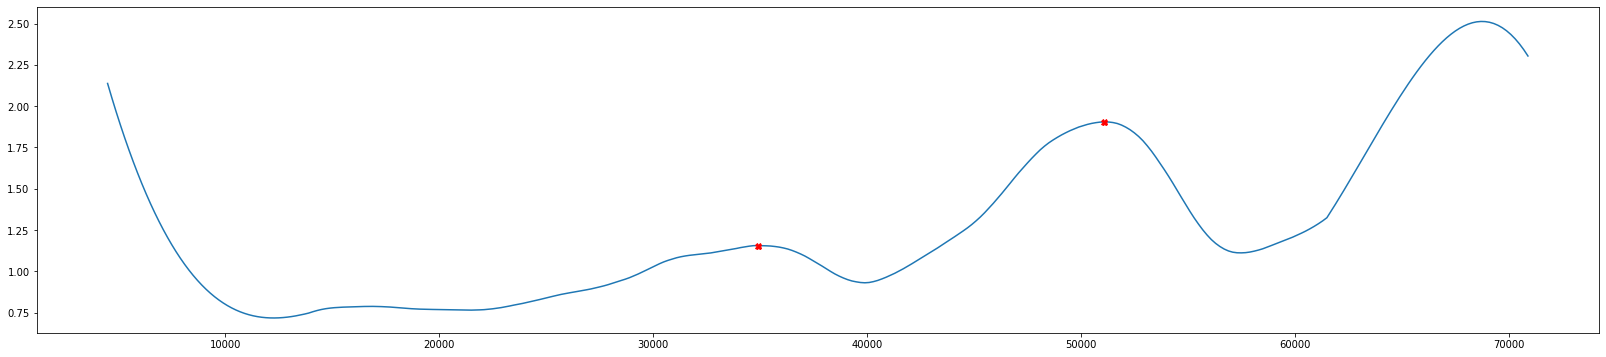

In [22]:
plt.figure(figsize=(28, 6))
plt.plot(mashaStressMetricsWithState["state"], label="ЭКГ")
plt.plot(mashaStressMetricsWithState["state"][mashaStressStatePeaks], "X", color = "r", label='R-зубцы')
plt.show()

# Нахождение временных границ интересующего состояния

In [23]:
def calcStateBorders(sourceState, statePeaks):
    angles = [10]

    for i in range(1, len(statePeaks)):
        angle = (sourceState[statePeaks[i]] - sourceState[statePeaks[i - 1]]) / (statePeaks[i] - statePeaks[i - 1])
        angles.append(abs(angle))

    stateIndex = angles.index(min(angles))
    stateStart = statePeaks[stateIndex - 1]
    stateEnd = statePeaks[stateIndex]
    
    return stateStart, stateEnd

In [24]:
lyubaStressStateStart, lyubaStressStateEnd = calcStateBorders(lyubaStressMetricsWithState["stateObratniy"], lyubaStressStatePeaks)
lyubaNormalStateStart, lyubaNormalStateEnd = calcStateBorders(lyubaNormalMetricsWithState["stateObratniy"], lyubaNormalStatePeaks)
lyubaMonotonyStateStart, lyubaMonotonyStateEnd = calcStateBorders(lyubaMonotonyMetricsWithState["stateObratniy"], lyubaMonotonyStatePeaks)

arinaStressStateStart, arinaStressStateEnd = calcStateBorders(arinaStressMetricsWithState["stateObratniy"], arinaStressStatePeaks)
arinaNormalStateStart, arinaNormalStateEnd = calcStateBorders(arinaNormalMetricsWithState["stateObratniy"], arinaNormalStatePeaks)
arinaMonotonyStateStart, arinaMonotonyStateEnd = calcStateBorders(arinaMonotonyMetricsWithState["stateObratniy"], arinaMonotonyStatePeaks)

mashaStressStateStart, mashaStressStateEnd = calcStateBorders(mashaStressMetricsWithState["stateObratniy"], mashaStressStatePeaks)
mashaNormalStateStart, mashaNormalStateEnd = calcStateBorders(mashaNormalMetricsWithState["stateObratniy"], mashaNormalStatePeaks)
mashaMonotonyStateStart, mashaMonotonyStateEnd = calcStateBorders(mashaMonotonyMetricsWithState["stateObratniy"], mashaMonotonyStatePeaks)

print(mashaStressStateStart)
print(mashaStressStateEnd)

34900
51100


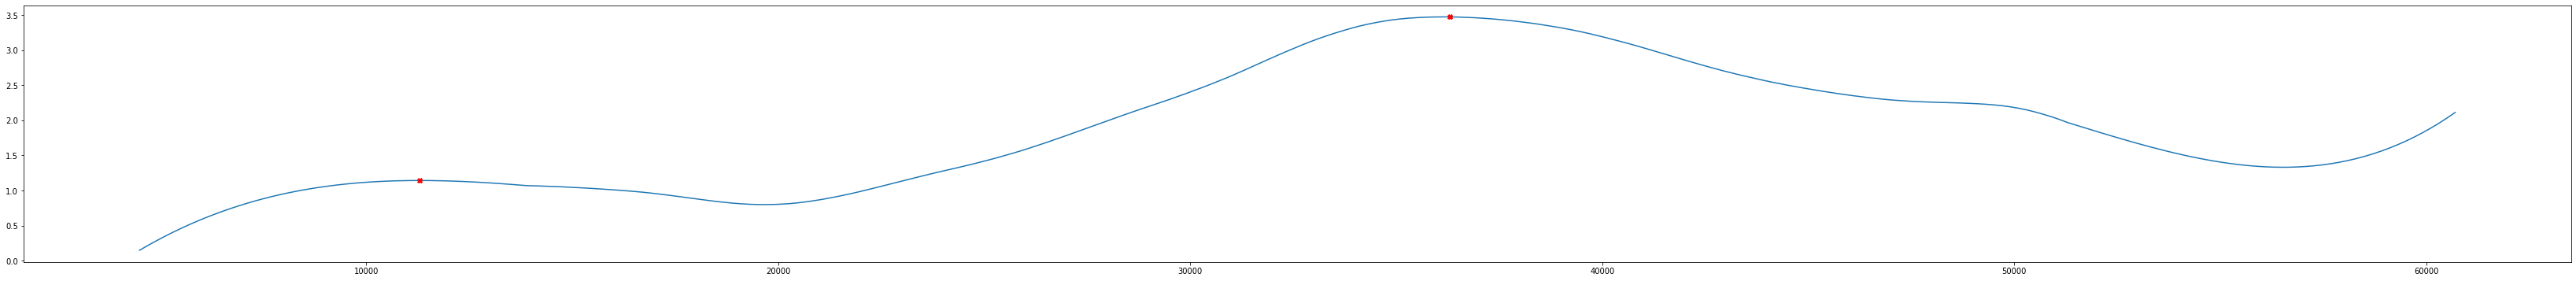

In [25]:
a = mashaNormalMetricsWithState["state"]
start = mashaNormalStateStart
end = mashaNormalStateEnd

plt.figure(figsize=(58, 6))
plt.plot(a, label="ЭКГ")
plt.plot(start, a[start], "X", color = "r", label='R-зубцы')
plt.plot(end, a[end], "X", color = "r", label='R-зубцы')
plt.show()

# Создание обучающей выборки

In [26]:
lyubaStressMLMetrics = lyubaStressMetrics
lyubaStressMLMetrics = lyubaStressMLMetrics.set_index('timeId')
lyubaNormalMLMetrics = lyubaNormalMetrics
lyubaNormalMLMetrics = lyubaNormalMLMetrics.set_index('timeId')
lyubaMonotonyMLMetrics = lyubaMonotonyMetrics
lyubaMonotonyMLMetrics = lyubaMonotonyMLMetrics.set_index('timeId')

arinaStressMLMetrics = arinaStressMetrics
arinaStressMLMetrics = arinaStressMLMetrics.set_index('timeId')
arinaNormalMLMetrics = arinaNormalMetrics
arinaNormalMLMetrics = arinaNormalMLMetrics.set_index('timeId')
arinaMonotonyMLMetrics = arinaMonotonyMetrics
arinaMonotonyMLMetrics = arinaMonotonyMLMetrics.set_index('timeId')

mashaStressMLMetrics = mashaStressMetrics
mashaStressMLMetrics = mashaStressMLMetrics.set_index('timeId')
mashaNormalMLMetrics = mashaNormalMetrics
mashaNormalMLMetrics = mashaNormalMLMetrics.set_index('timeId')
mashaMonotonyMLMetrics = mashaMonotonyMetrics
mashaMonotonyMLMetrics = mashaMonotonyMLMetrics.set_index('timeId')

lyubaMonotonyfilteredFPGs, lyubaMonotonyfpgPeaks, lyubaMonotonysystolePeaks, lyubaMonotonyfilteredECGs, lyubaMonotonyrPeaks, lyubaMonotonyrrIntervals, lyubaFinalMetrics = calsMetrics(lyubaMonotony)
lyubaFinalMetrics

arinaMonotonyfilteredFPGs, arinaMonotonyfpgPeaks, arinaMonotonysystolePeaks, arinaaMonotonyfilteredECGs, arinaMonotonyrPeaks, arinaMonotonyrrIntervals, arinaFinalMetrics = calsMetrics(arinaMonotony)

mashaMonotonyfilteredFPGs, mashaMonotonyfpgPeaks, mashaMonotonysystolePeaks, amashaMonotonyfilteredECGs, mashaMonotonyrPeaks, mashaMonotonyrrIntervals, mashaFinalMetrics = calsMetrics(mashaMonotony)

mashaFinalMetrics.tail(1)

timeId       meanGSR    gsrStd  corrGSRECG  meanDifRSysFPG     LF/HF  \
431  90700.0 -3.349350e-14  2.715448    0.240396           12.08  8.213094   

     meanError  numberOfPeaks  meanAccuracy  difficult  PulseRR   PulseStd  \
431   1.554127           62.0     98.445873       3.75     71.0  58.246916   

      MoRR  StdRR   CVRR  MoInt  AMoInt  DXInt  VPRInt  INInt  
431  0.844  0.058  6.872   0.81   29.03   0.26    4.75  68.92

In [27]:
lyubaStressMLMetrics = lyubaStressMLMetrics[lyubaStressStateStart : lyubaStressStateEnd]
lyubaNormalMLMetrics = lyubaNormalMLMetrics[lyubaNormalStateStart : lyubaNormalStateEnd]
lyubaMonotonyMLMetrics = lyubaMonotonyMLMetrics[lyubaMonotonyStateStart : lyubaMonotonyStateEnd]

arinaStressMLMetrics = arinaStressMLMetrics[arinaStressStateStart : arinaStressStateEnd]
arinaNormalMLMetrics = arinaNormalMLMetrics[arinaNormalStateStart : arinaNormalStateEnd]
arinaMonotonyMLMetrics = arinaMonotonyMLMetrics[arinaMonotonyStateStart : arinaMonotonyStateEnd]

mashaStressMLMetrics = mashaStressMLMetrics[mashaStressStateStart : mashaStressStateEnd]
mashaNormalMLMetrics = mashaNormalMLMetrics[mashaNormalStateStart : mashaNormalStateEnd]
mashaMonotonyMLMetrics = mashaMonotonyMLMetrics[mashaMonotonyStateStart : mashaMonotonyStateEnd]

print(len(mashaStressMLMetrics))
print(len(mashaNormalMLMetrics))
print(len(mashaMonotonyMLMetrics))

82
126
145


In [28]:
lyubaMonotonyMLMetrics["target"] = 0
lyubaNormalMLMetrics["target"]   = 1
lyubaStressMLMetrics["target"]   = 2

arinaMonotonyMLMetrics["target"] = 0
arinaNormalMLMetrics["target"]   = 1
arinaStressMLMetrics["target"]   = 2

mashaMonotonyMLMetrics["target"] = 0
mashaNormalMLMetrics["target"]   = 1
mashaStressMLMetrics["target"]   = 2

mlMetricsLyuba = lyubaMonotonyMLMetrics.append(lyubaNormalMLMetrics, ignore_index = True)
mlMetricsLyuba = mlMetricsLyuba.append(lyubaStressMLMetrics, ignore_index = True)

mlMetricsArina = arinaMonotonyMLMetrics.append(arinaNormalMLMetrics, ignore_index = True)
mlMetricsArina = mlMetricsArina.append(arinaStressMLMetrics, ignore_index = True)

mlMetricsMasha = mashaMonotonyMLMetrics.append(mashaNormalMLMetrics, ignore_index = True)
mlMetricsMasha = mlMetricsMasha.append(mashaStressMLMetrics, ignore_index = True)

mlMetricsMasha.tail(1)

meanGSR     gsrStd  corrGSRECG  meanDifRSysFPG    LF/HF  meanError  \
352 -2.788497e-14  20.204878   -0.192395        8.966667  0.59962   6.702364   

     numberOfPeaks  meanAccuracy  difficult  PulseRR    PulseStd   MoRR  \
352          140.0     93.297636   18.42975     72.0  182.479592  0.839   

     StdRR    CVRR  MoInt  AMoInt  DXInt  VPRInt  INInt  target  
352  0.182  21.692   0.85   18.57    0.9    1.31  12.14       2

In [29]:
mlMetricsLyuba = mlMetricsLyuba.drop('difficult', axis=1)
mlMetricsLyuba = mlMetricsLyuba.drop('numberOfPeaks', axis=1)
mlMetricsLyuba = mlMetricsLyuba.drop('meanAccuracy', axis=1)
mlMetricsLyuba = mlMetricsLyuba.drop('meanError', axis=1)
mlMetricsLyuba = mlMetricsLyuba.drop('meanGSR', axis=1)

mlMetricsArina = mlMetricsArina.drop('difficult', axis=1)
mlMetricsArina = mlMetricsArina.drop('numberOfPeaks', axis=1)
mlMetricsArina = mlMetricsArina.drop('meanAccuracy', axis=1)
mlMetricsArina = mlMetricsArina.drop('meanError', axis=1)
mlMetricsArina = mlMetricsArina.drop('meanGSR', axis=1)

mlMetricsMasha = mlMetricsMasha.drop('difficult', axis=1)
mlMetricsMasha = mlMetricsMasha.drop('numberOfPeaks', axis=1)
mlMetricsMasha = mlMetricsMasha.drop('meanAccuracy', axis=1)
mlMetricsMasha = mlMetricsMasha.drop('meanError', axis=1)
mlMetricsMasha = mlMetricsMasha.drop('meanGSR', axis=1)

mlMetricsMasha.tail(1)

gsrStd  corrGSRECG  meanDifRSysFPG    LF/HF  PulseRR    PulseStd  \
352  20.204878   -0.192395        8.966667  0.59962     72.0  182.479592   

      MoRR  StdRR    CVRR  MoInt  AMoInt  DXInt  VPRInt  INInt  target  
352  0.839  0.182  21.692   0.85   18.57    0.9    1.31  12.14       2

In [30]:
X_lyuba = mlMetricsLyuba.drop('target', axis=1)  
y_lyuba = mlMetricsLyuba['target'] 
X_train_lyuba, X_test_lyuba, y_train_lyuba, y_test_lyuba = train_test_split(X_lyuba, y_lyuba, test_size=1, random_state=42)
print(str(len(X_train_lyuba)) + " " + str(len(y_train_lyuba)))
print(str(len(X_test_lyuba)) + " " + str(len(y_test_lyuba)))

X_arina = mlMetricsArina.drop('target', axis=1)  
y_arina = mlMetricsArina['target'] 
X_train_arina, X_test_arina, y_train_arina, y_test_arina = train_test_split(X_arina, y_arina, test_size=1, random_state=42)
print(str(len(X_train_arina)) + " " + str(len(y_train_arina)))
print(str(len(X_test_arina)) + " " + str(len(y_test_arina)))

X_masha = mlMetricsMasha.drop('target', axis=1)  
y_masha = mlMetricsMasha['target'] 
X_train_masha, X_test_masha, y_train_masha, y_test_masha = train_test_split(X_masha, y_masha, test_size=1, random_state=42)
print(str(len(X_train_masha)) + " " + str(len(y_train_masha)))
print(str(len(X_test_masha)) + " " + str(len(y_test_masha)))

330 330
1 1
229 229
1 1
352 352
1 1


# Обучение классификационных моделей

In [31]:
forest_arina = RandomForestClassifier(n_estimators = 200)
forest_arina.fit(X_train_arina, y_train_arina)

forest_lyuba = RandomForestClassifier(n_estimators = 200)
forest_lyuba.fit(X_train_lyuba, y_train_lyuba)

forest_masha = RandomForestClassifier(n_estimators = 200)
forest_masha.fit(X_train_masha, y_train_masha)

RandomForestClassifier(n_estimators=200)

In [33]:
knn_arina = KNeighborsClassifier(n_neighbors=3)
knn_arina.fit(X_train_arina, y_train_arina)

knn_lyuba = KNeighborsClassifier(n_neighbors=3)
knn_lyuba.fit(X_train_lyuba, y_train_lyuba)

knn_masha = KNeighborsClassifier(n_neighbors=3)
knn_masha.fit(X_train_masha, y_train_masha)

KNeighborsClassifier(n_neighbors=3)

In [34]:
clf_arina = MLPClassifier(random_state=1, max_iter = 1000, hidden_layer_sizes = (400, 400))
clf_arina.fit(X_train_arina, y_train_arina)

clf_lyuba = MLPClassifier(random_state=1, max_iter = 1000, hidden_layer_sizes = (400, 400))
clf_lyuba.fit(X_train_lyuba, y_train_lyuba)

clf_masha = MLPClassifier(random_state=1, max_iter = 1000, hidden_layer_sizes = (400, 400))
clf_masha.fit(X_train_masha, y_train_masha)

MLPClassifier(hidden_layer_sizes=(400, 400), max_iter=1000, random_state=1)

In [35]:
# testMetricsLyuba = lyubaMonotonyMetrics
# testMetricsLyuba = lyubaNormalMetrics
testMetricsLyuba = lyubaStressMetrics

testMetricsArina = arinaMonotonyMetrics
# testMetricsArina = arinaNormalMetrics
# testMetricsArina = arinaStressMetrics

# testMetricsMasha = mashaMonotonyMetrics
testMetricsMasha = mashaNormalMetrics
# testMetricsMasha = mashaStressMetrics

testMetricsLyuba = testMetricsLyuba.drop('timeId', axis=1)
testMetricsLyuba = testMetricsLyuba.drop('difficult', axis=1)
testMetricsLyuba = testMetricsLyuba.drop('numberOfPeaks', axis=1)
testMetricsLyuba = testMetricsLyuba.drop('meanAccuracy', axis=1)
testMetricsLyuba = testMetricsLyuba.drop('meanError', axis=1)
testMetricsLyuba = testMetricsLyuba.drop('meanGSR', axis=1)

testMetricsArina = testMetricsArina.drop('timeId', axis=1)
testMetricsArina = testMetricsArina.drop('difficult', axis=1)
testMetricsArina = testMetricsArina.drop('numberOfPeaks', axis=1)
testMetricsArina = testMetricsArina.drop('meanAccuracy', axis=1)
testMetricsArina = testMetricsArina.drop('meanError', axis=1)
testMetricsArina = testMetricsArina.drop('meanGSR', axis=1)

testMetricsMasha = testMetricsMasha.drop('timeId', axis=1)
testMetricsMasha = testMetricsMasha.drop('difficult', axis=1)
testMetricsMasha = testMetricsMasha.drop('numberOfPeaks', axis=1)
testMetricsMasha = testMetricsMasha.drop('meanAccuracy', axis=1)
testMetricsMasha = testMetricsMasha.drop('meanError', axis=1)
testMetricsMasha = testMetricsMasha.drop('meanGSR', axis=1)

testMetricsMasha.tail(1)

gsrStd  corrGSRECG  meanDifRSysFPG     LF/HF  PulseRR   PulseStd   MoRR  \
281  4.91638    0.188701        11.52381  8.331531     73.0  66.962143  0.825   

     StdRR   CVRR  MoInt  AMoInt  DXInt  VPRInt  INInt  
281  0.067  8.121   0.81   21.54   0.26    4.75  51.14

In [36]:
y_pred_forest_arina = forest_arina.predict(testMetricsArina)
y_pred_nn_arina = clf_arina.predict(testMetricsArina)
y_pred_knn_arina = knn_arina.predict(testMetricsArina)

y_pred_forest_lyuba = forest_lyuba.predict(testMetricsLyuba)
y_pred_nn_lyuba = clf_lyuba.predict(testMetricsLyuba)
y_pred_knn_lyuba = knn_lyuba.predict(testMetricsLyuba)

y_pred_forest_masha = forest_masha.predict(testMetricsMasha)
y_pred_nn_masha = clf_masha.predict(testMetricsMasha)
y_pred_knn_masha = knn_masha.predict(testMetricsMasha)

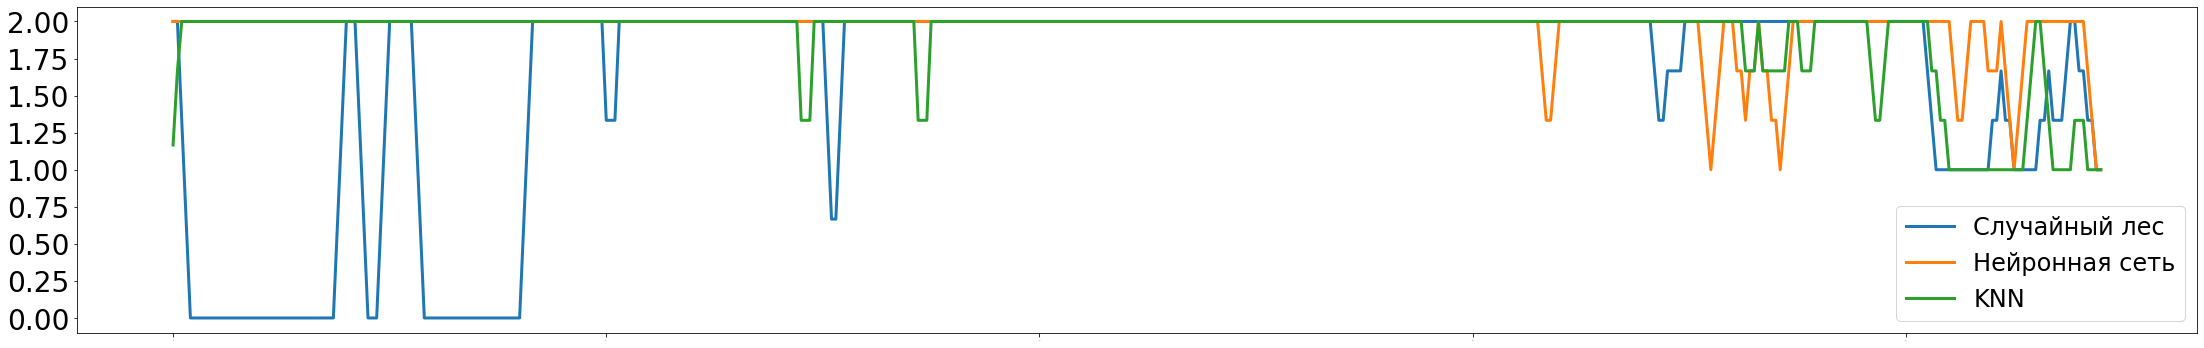

In [37]:
plt.figure(figsize=(38, 6))
# plt.plot(testMetricsArina.index, savgol_filter(y_pred_forest_arina, 3, 1), label="Случайный лес", linewidth= 3)
plt.plot(testMetricsLyuba.index, savgol_filter(y_pred_forest_lyuba, 3, 1), label="Случайный лес", linewidth= 3)
# plt.plot(testMetricsMasha.index, savgol_filter(y_pred_forest_masha, 3, 1), label="Случайный лес", linewidth= 3)
# plt.plot(testMetricsArina.index, savgol_filter(y_pred_nn_arina, 3, 1), label="Нейронная сеть", linewidth= 3)
plt.plot(testMetricsLyuba.index, savgol_filter(y_pred_nn_lyuba, 3, 1), label="Нейронная сеть", linewidth= 3)
# plt.plot(testMetricsMasha.index, savgol_filter(y_pred_nn_masha, 3, 1), label="Нейронная сеть", linewidth= 3)
# plt.plot(testMetricsArina.index, savgol_filter(y_pred_knn_arina, 3, 1), label="KNN", linewidth= 3)
plt.plot(testMetricsLyuba.index, savgol_filter(y_pred_knn_lyuba, 3, 1), label="KNN", linewidth= 3)
# plt.plot(testMetricsMasha.index, savgol_filter(y_pred_knn_masha, 3, 1), label="KNN", linewidth= 3)
plt.legend(loc='best', fontsize = 24)
plt.yticks(size = 28)
plt.xticks(size = 0)
plt.show()

# 

# 

# Апробация

In [38]:
lyubaFinal["leftErrors"] = 0
lyubaFinal["centreErrors"] = 0
lyubaFinal["rightErrors"] = 0
lyubaFinal["difficult"] = 0

lyubaFinalfilteredFPGs, lyubaFinalfpgPeaks, lyubaFinalsystolePeaks, lyubaFinalfilteredECGs, lyubaFinalrPeaks, lyubaFinalrrIntervals, lyubaFinalMetrics = calsMetrics(lyubaFinal)
lyubaFinalMetrics.head(1)

timeId       meanGSR     gsrStd  corrGSRECG  meanDifRSysFPG     LF/HF  \
0  4500.0  1.858998e-14  13.547777    0.094712        9.803571  0.934497   

   meanError  numberOfPeaks  meanAccuracy  difficult  PulseRR    PulseStd  \
0        NaN          143.0           NaN        0.0     73.0  275.135065   

    MoRR  StdRR    CVRR  MoInt  AMoInt  DXInt  VPRInt  INInt  
0  0.818  0.275  33.619   1.17     1.4   1.55    0.55   0.39

In [39]:
finalMetrics = lyubaFinalMetrics

finalMetrics = finalMetrics.drop('timeId', axis=1)
finalMetrics = finalMetrics.drop('difficult', axis=1)
finalMetrics = finalMetrics.drop('numberOfPeaks', axis=1)
finalMetrics = finalMetrics.drop('meanAccuracy', axis=1)
finalMetrics = finalMetrics.drop('meanError', axis=1)
finalMetrics = finalMetrics.drop('meanGSR', axis=1)

In [40]:
y_pred_forest_final = forest_lyuba.predict(finalMetrics)
y_pred_nn_final = clf_lyuba.predict(finalMetrics)
y_pred_knn_final = knn_lyuba.predict(finalMetrics)

In [174]:
windowStep = 200 # 10 секунд при частоте в 38 ГЦ
windowWidth = 4500 # 2 минуты при частоте в 38 ГЦ

difficult = []
    
for i in range(0, len(lyubaFinal), windowStep):
    dataFrame = lyubaFinal.loc[i : i + windowWidth]
    difficult.append(dataFrame["difficulties"].mean() / 5)
#     difficult.append(dataFrame.tail(1)["difficulties"] / 8)

difficult = difficult - (sum(difficult) / len(difficult))
difficult = difficult[0:len(y_pred_forest_final)]

In [190]:
def calcF1(y_pred, difficult):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for i in range(len(y_pred)):
        if 0.68 < y_pred[i] < 1.33 and difficult[i] > 0:
            TP += 1
        elif 0.68 < y_pred[i] < 1.33 and difficult[i] < 0:
            FP += 1
        elif (y_pred[i] < 0.67 or y_pred[i] > 1.34) and difficult[i] > 0:
            FN += 1
        else:
            TN += 1
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 2 * (precision * recall) / (precision + recall)
    return F1, TP, TN, FP, FN

In [192]:
forestF1, TP, TN, FP, FN = calcF1(savgol_filter(y_pred_forest_final, 3, 1), difficult)
print(forestF1, TP, TN, FP, FN)
nntF1, TP, TN, FP, FN = calcF1(savgol_filter(y_pred_nn_final, 3, 1), difficult)
print(nntF1, TP, TN, FP, FN)
knnF1, TP, TN, FP, FN = calcF1(savgol_filter(y_pred_knn_final, 3, 1), difficult)
print(knnF1, TP, TN, FP, FN)

0.5882352941176471 75 131 64 41
0.10256410256410256 6 200 1 104
0.07692307692307693 5 186 7 113


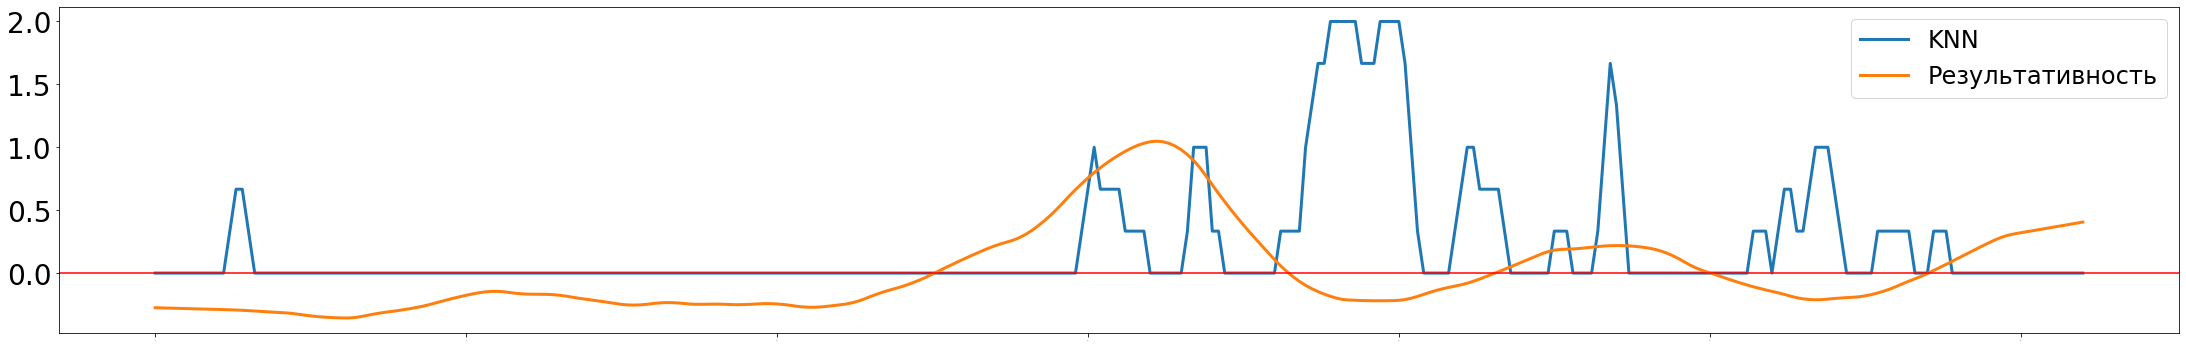

In [195]:
plt.figure(figsize=(38, 6))
# plt.plot(finalMetrics.index, savgol_filter(y_pred_forest_final, 3, 1), label="Случайный лес", linewidth= 3)
# plt.plot(finalMetrics.index, savgol_filter(y_pred_nn_final, 3, 1), label="Нейронная сеть", linewidth= 3)
plt.plot(finalMetrics.index, savgol_filter(y_pred_knn_final, 3, 1), label="KNN", linewidth= 3)
plt.plot(savgol_filter(difficult, 23, 1), label="Результативность", linewidth= 3)
# plt.plot(savgol_filter(difficult, 3, 1) * savgol_filter(y_pred_forest_final, 3, 1), label="a", linewidth= 3)
# plt.plot(difficult, label="Результативность", linewidth= 3)
plt.legend(loc='best', fontsize = 24)
plt.yticks(size = 28)
plt.xticks(size = 0)
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# 

# 

# 

# 

# 

# 

# 

# 